In [208]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [70]:
#db Connection String
# Create a database connection
user = 'postgres'
host = 'xx.xxx.xx.xxx'
dbname = 'mimic'
schema = 'mimiciii'
password ='xxxx'
port = '5432'

In [71]:
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=user, host=host,port=port,password=password)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema))

In [ ]:
# Get length of stay from the icustays table
query = \
"""
SELECT * FROM admission_details
order by subject_id, admittime,intime;
"""

df_admission_details = pd.read_sql_query(query,con)
df_admission_details.to_csv('../data/admission_details_2.csv',index=False)

In [2]:
df_admission_details=pd.read_csv('../data/admission_details_2.csv')
df_admission_details.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,icustay_id,intime,outtime,last_wardid,first_careunit,last_careunit,age,gender,marital_status,insurance
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,243653,2138-07-17 21:20:07,2138-07-17 23:32:21,56,NICU,NICU,0.002175,M,NaN,Private
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,211552,2101-10-20 19:10:11,2101-10-26 20:43:09,12,MICU,MICU,76.526788,M,MARRIED,Medicare
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,294638,2191-03-16 00:29:31,2191-03-17 16:46:31,52,MICU,MICU,47.845044,F,SINGLE,Private
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,214757,2103-02-02 06:04:24,2103-02-02 08:06:00,56,NICU,NICU,0.000515,M,NaN,Private
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,228232,2175-05-30 21:30:54,2175-06-03 13:39:54,33,SICU,SICU,65.940670,F,MARRIED,Medicare


In [3]:
#Add column to show if readmitted
readmit_data=df_admission_details.assign(IsReadmitted=0)

In [4]:
#convert dates from string to datetime
readmit_data['admittime'] = readmit_data['admittime'].astype('datetime64[ns]')
readmit_data['dischtime'] = readmit_data['dischtime'].astype('datetime64[ns]')
readmit_data['intime'] = readmit_data['intime'].astype('datetime64[ns]')

#for missing outtime, assuming icu out time was same as discharged time
readmit_data.loc[readmit_data['outtime'].isnull(),'outtime'] = readmit_data['dischtime']
readmit_data['outtime'] = readmit_data['outtime'].astype('datetime64[ns]')

In [5]:
#total number of admissions
num_adms = readmit_data.shape[0]

for idx in range(1,num_adms):
    if readmit_data.subject_id[idx] == readmit_data.subject_id[idx - 1]:
        

        
        '''
        prev_dischtime = readmit_data.dischtime[idx-1]
        curr_admittime = readmit_data.admittime[idx] 
        
        readmit_time = curr_admittime - prev_dischtime
        if readmit_time.days <0:
            print(readmit_data.subject_id[idx])
        '''
        #previous icu discharge time
        prev_outtime = readmit_data.outtime[idx-1]
        #current icu admit time
        curr_intime = readmit_data.intime[idx] 
        
        readmit_time = curr_intime - prev_outtime
        if readmit_time.days <31:
            readmit_data.loc[idx-1, 'IsReadmitted'] = 1

In [10]:
readmit_data.to_csv('../data/readmits_details.csv',index=False)

In [8]:
df_readmission = pd.read_csv('../data/readmits_details.csv')

In [4]:
df_readmission.shape

(61532, 16)

In [12]:
#removing ppl less than 15 years of age
df_readmission=df_readmission[(df_readmission.age>=15)]

In [13]:
#removing ppl more than 90 years of age
df_readmission=df_readmission[(df_readmission.age<=90)]

In [14]:
df_readmission.shape

(50710, 16)

In [15]:
df_readm_clean=df_readmission.drop(['deathtime','admittime','dischtime','intime','outtime'], axis=1)

In [16]:
df_readm_clean.shape

(50710, 11)

In [17]:
df_readm_clean_2= df_readm_clean.sort_values(['subject_id', 'hadm_id','IsReadmitted'],ascending=[True,True, False])

In [38]:
df_readm_clean_2.shape

(50710, 11)

In [42]:
sum(df_readm_clean_2['IsReadmitted'])*100/len(df_readm_clean['IsReadmitted'])

11.778741865509762

In [18]:
df_readm_clean_2.head()

,subject_id,hadm_id,icustay_id,last_wardid,first_careunit,last_careunit,age,gender,marital_status,insurance,IsReadmitted
1,3,145834,211552,12,MICU,MICU,76.526788,M,MARRIED,Medicare,0
2,4,185777,294638,52,MICU,MICU,47.845044,F,SINGLE,Private,0
4,6,107064,228232,33,SICU,SICU,65.940670,F,MARRIED,Medicare,0
8,9,150750,220597,15,MICU,MICU,41.790226,M,NaN,Medicaid,0
10,11,194540,229441,57,SICU,SICU,50.148292,F,MARRIED,Private,0


In [19]:
df_readm_clean_2.to_csv('../data/clean_readm_details.csv',index=False)

In [20]:
df_readm_clean_3 = pd.read_csv('../data/clean_readm_details.csv')

In [62]:

from sklearn.model_selection import train_test_split
orig, subsample = train_test_split(df_readm_clean_3, test_size=10/500, random_state=20)
sum(subsample['IsReadmitted'])*100/len(subsample['IsReadmitted'])

11.822660098522167

In [63]:
subsample.shape

(1015, 11)

In [64]:
sum(subsample['IsReadmitted'])*100/len(subsample['IsReadmitted'])

11.822660098522167

In [66]:
subsample.to_csv('../data/subsample.csv',index=False)

In [67]:
subsample=subsample.reset_index(drop=True)

In [68]:
subsample['icustay_id'].to_csv('../data/icustay_ids.csv')

In [72]:
# Get length of stay from the icustays table
query = \
"""
SELECT * FROM charts_details;
"""

df_charts_details = pd.read_sql_query(query,con)
df_charts_details.to_csv('../data/df_charts_details_2.csv',index=False)

In [73]:
df_charts_details.shape

(6282992, 5)

In [79]:
from collections import Counter
cntr = Counter(df_charts_details['itemid'])
freq_item_ids=[item_id for item_id,_ in cntr.most_common(200)]
#print(Counter(df_charts_details['itemid']))

In [83]:
df_charts_subset = df_charts_details.loc[df_charts_details['itemid'].isin(freq_item_ids)]

In [88]:
len(set(df_charts_subset.icustay_id))

996

In [89]:
df_charts_subset.to_csv('../data/df_charts_subset.csv',index=False)

In [13]:
from datetime import datetime
#headers = ['icustay_id', 'itemid','charttime'] 

#dtypes = [int,int,datetime.datetime] 

df_charts_subset = pd.read_csv('../data/df_charts_subset.csv',low_memory=False,dtype={"itemid": int, "icustay_id": int})

In [16]:
df_charts_subset['charttime'] = df_charts_subset['charttime'].astype('datetime64[ns]')

In [19]:
icu=set(df_charts_subset.icustay_id)

In [21]:
len(icu)

996

In [25]:
subsample=pd.read_csv('../data/subsample.csv')

In [23]:
df_new_subset = subsample.loc[subsample['icustay_id'].isin(icu)]

In [27]:
df_new_subset.shape

(996, 11)

In [28]:
sum(df_new_subset['IsReadmitted'])*100/len(df_new_subset['IsReadmitted'])

11.947791164658634

In [1]:
import pandas as pd

In [234]:
df_charts_subset = pd.read_csv('../data/df_charts_subset.csv',low_memory=False,dtype={"itemid": int, "icustay_id": int})

In [237]:
df_charts_subset['charttime'] = df_charts_subset['charttime'].astype('datetime64[ns]')

In [244]:
sum(df_charts_subset['valuenum'].isnull())*100/len(df_charts_subset['valuenum'])

43.768512233086582

In [245]:
sum(df_charts_subset['value'].isnull())*100/len(df_charts_subset['value'])

0.38974630316450692

In [247]:
df_charts_subset.value.dtype

dtype('O')

In [32]:
len(set(df_charts_subset.icustay_id))

996

In [146]:
df_charts_subset = pd.read_csv('../data/df_charts_subset.csv',low_memory=False,dtype={"itemid": int, "icustay_id": int})
df_charts_subset['charttime'] = df_charts_subset['charttime'].astype('datetime64[ns]')

In [147]:
df_charts_subset.shape

(4188109, 5)

In [197]:
df_indexed = df_charts_subset
df_indexed['valuenum'].fillna(df_indexed['value'],inplace=True)
df_indexed=df_indexed.drop(['value'],axis=1)
df_indexed=df_indexed.groupby('icustay_id').apply(lambda x: x.sort_values('charttime'))
df_indexed=df_indexed.drop(['icustay_id'],axis=1)
df_indexed['charttime']=df_indexed.groupby(level=['icustay_id'])['charttime'].apply(lambda x: x-x.iloc[0])
df_indexed = pd.pivot_table(df_indexed, index=['icustay_id', 'charttime'], columns='itemid', values='valuenum',aggfunc='first')

In [198]:
df_indexed.head()

itemid               27     31     32     39     40     49     51     52      \
icustay_id charttime                                                           
200010     00:00:00    None   None   None   None   None   None   None   None   
           00:39:00    None   None   None   None   None   None   None   None   
           00:40:00    None   None   None   None   None   None   None   None   
           00:44:00    None   None   None   None   None   None   None   None   
           00:52:00    None   None   None   None   None   None   None   None   

itemid               54     77      ...   224756 225054 226104 226732 226871  \
icustay_id charttime                ...                                        
200010     00:00:00    None   None  ...     None   None   None   None   None   
           00:39:00    None   None  ...     None   None   None   None   None   
           00:40:00    None   None  ...     None   None   None   None   None   
           00:44:00    None   None  ...     None   None   None   None   None   
           00:52:00    None   None  ...     None   None   None   None   None   

itemid               226873 227066 227944 227958 227969  
icustay_id charttime                                     
200010     00:00:00    None   None   None   None   None  
           00:39:00    None   None   None   None   None  
           00:40:00    None   None   None   None   None  
           00:44:00    None   None   None   None   None  
           00:52:00    None   None   None   None   None  

[5 rows x 200 columns]

In [205]:
eIdx = df_indexed.index.levels[0];

In [207]:
nobs = [df_indexed.loc[ix].index.shape[0] for ix in eIdx]

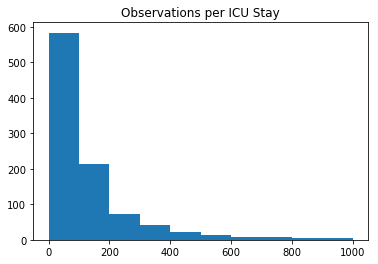

In [214]:
plt.hist(nobs,range=(0,1000))
plt.title("Observations per ICU Stay")
plt.show()

In [226]:
X_train = df_indexed

In [227]:
X_train.shape

(205055, 200)

In [232]:
X_train.count()*100/205055

itemid
27         7.175148
31         9.891980
32         8.680598
39         4.813343
40         5.122040
49         6.075443
51        21.268928
52        21.071908
54         8.803492
77         4.091098
80         6.914243
113       10.889761
127        4.349565
128       31.045329
154        7.973471
156        5.743337
159       24.161323
161       31.612007
171        4.468070
184        9.193631
190        5.581917
197        4.313477
198        9.111702
200        4.553900
203        3.757528
210        9.416010
211       33.983565
212       32.299139
218        3.954549
219        3.873107
            ...    
224084     7.517008
224085     4.716783
224086     6.961059
224087     5.391236
224089     4.528541
224093     6.616274
224168     4.727024
224641     4.835288
224642     5.807222
224650    17.552852
224684     7.240009
224685    19.302626
224686    14.316647
224687    18.675965
224688     7.311209
224689    19.208993
224690    18.931506
224695    19.295311
224697    19.

In [233]:
X_train.dtypes

itemid
27        object
31        object
32        object
39        object
40        object
49        object
51        object
52        object
54        object
77        object
80        object
113       object
127       object
128       object
154       object
156       object
159       object
161       object
171       object
184       object
190       object
197       object
198       object
200       object
203       object
210       object
211       object
212       object
218       object
219       object
           ...  
224084    object
224085    object
224086    object
224087    object
224089    object
224093    object
224168    object
224641    object
224642    object
224650    object
224684    object
224685    object
224686    object
224687    object
224688    object
224689    object
224690    object
224695    object
224697    object
224738    object
224756    object
225054    object
226104    object
226732    object
226871    object
226873    object
227066    object
227944 